In [2]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [3]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [4]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [5]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [6]:
import zipfile

# Make dir if it does not exist, then write csv to file in dir, return the directory
def df_to_csv(df, dir, file):
    if isinstance(dir, list):
        dir = '/'.join(dir)
    csv = '/'.join([dir, 'raw', file])
    zip = '/'.join([dir, 'zip', file + '.zip'])
    for file in [csv, zip]:
        folder = os.path.dirname(file)
        if not os.path.exists(folder):
            os.makedirs(folder)
    df.to_csv(csv)
    # Create a zip file and add the input CSV file to it
    with zipfile.ZipFile(zip, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
        zipf.write(csv, os.path.basename(csv))
    
    return dir

# Default directory for this file output
output_dir = ['output']

# Reddit Subreddit API analysis

Subreddit Stats
+----------------------+-------------+-----------------+
|         name         | subscribers | subscribers_pct |
+----------------------+-------------+-----------------+
|       chatgpt        |   4505500   |      36.55      |
|   machinelearning    |   2870456   |      23.28      |
|     datascience      |   1366348   |      11.08      |
|        openai        |   1124730   |       9.12      |
|         gpt3         |    722076   |       5.86      |
|      artificial      |    720095   |       5.84      |
| learnmachinelearning |    384514   |       3.12      |
| chatgptpromptgenius  |    193280   |       1.57      |
|       datasets       |    187702   |       1.52      |
|     deeplearning     |    149090   |       1.21      |
|    chatgptcoding     |    104361   |       0.85      |
+----------------------+-------------+-----------------+


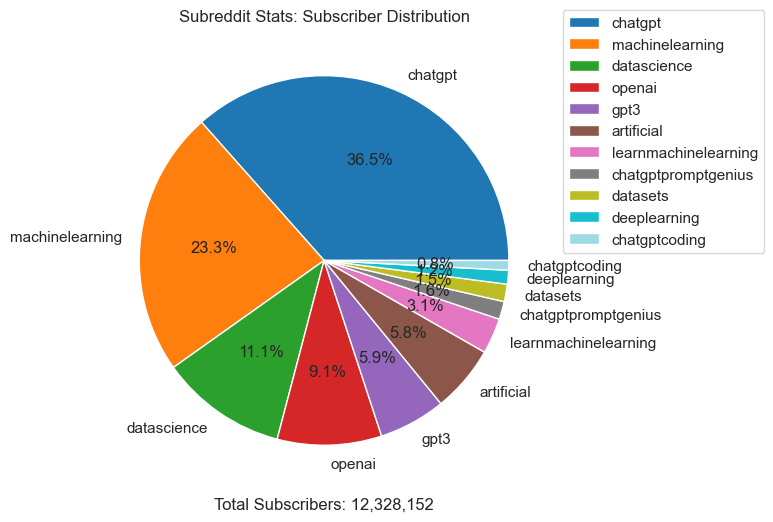

In [7]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('./data/**/*.meta'), recursive=True):
    _metadata = pd.read_csv(fname)
    # Drop the column 'Unnamed: 0'
    _metadata.drop(columns=['Unnamed: 0'], inplace=True)
    _metadata['display_name'] = _metadata['name']
    _metadata['name'] = _metadata['name'].str.lower()
    metadata = metadata.append(_metadata.copy(), ignore_index=True)
    #print(fname)
    #break #DEBUG

# Drop duplicates from the 'name' column
metadata.reset_index(inplace=True)  # Reset index
metadata.drop_duplicates(subset='name', inplace=True)  # Drop duplicates based on the 'name' column
metadata.sort_values(by='subscribers', ascending=False, inplace=True)

# filter subreddits with less than 100,000 subscribers
metadata = metadata[metadata['subscribers'] > 100000]
# Calculate subscribers as a percentage of the total
total_subscribers = metadata['subscribers'].sum()
metadata['subscribers_pct'] = (metadata['subscribers'] / total_subscribers) * 100

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata[['name','subscribers','subscribers_pct']].columns
# Add rows to the table
for row in metadata[table.field_names].itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# After printing, set name as the index
metadata.set_index('name', inplace=True)  # Set the 'name' column as the index of the DataFrame

# Write output file
df_to_csv(metadata, output_dir, 'subreddits.meta')

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(metadata)))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=colors)
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(total_subscribers))
plt.show()

# Reddit Search API data analysis

In [7]:
# Reddit posts data structure
posts_dict_template = {"id":[],
                        "subreddit":[],
                        "query":[],
                        "sort":[],
                        "date":[],
                        "title":[],
                        "author":[],
                        "stickied":[],
                        "upvote_ratio":[],
                        "score":[],
                        "url":[],
                        "num_comments": [],
                        "created": [],
                        "body":[]}

# Import query data
df_posts = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/posts.csv'), recursive=True):
    _df=pd.read_csv(fname)

    # Check for empty dataset
    if _df.empty: continue
    # Drop the column 'Unnamed: 0'
    _df.drop(columns=['Unnamed: 0'], inplace=True)
    _df['subreddit'] = _df[_df['subreddit'].str.lower().isin(metadata.index)]['subreddit'].str.lower()
    # Remove missing subreddit values
    _df = _df[_df['subreddit'].notna()]
    if _df.empty: continue

    # Append the dataset with calculated columns to the complete dataset
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    df_posts = pd.concat([df_posts, _df], ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

# remove duplicate posts
df_posts.reset_index(inplace=True)  # Reset index
df_posts.drop_duplicates(subset='id', inplace=True)  # Drop duplicates based on the 'id' column
df_posts.set_index('id', inplace=True)  # Set the 'id' column as the index of the DataFrame

# Output data to CSV
df_to_csv(df_posts, output_dir, 'posts.csv')

print(f"Total imported Reddit posts: {running_total}")
print(f"Duplicate cross-subreddit posts: {running_total-len(df_posts)}")
print(f"De-duplicated reddit posts: {len(df_posts)}")

Total imported Reddit posts: 9822
Duplicate cross-subreddit posts: 7345
De-duplicated reddit posts: 2477


# Reddit Comment API data analysis

In [8]:
# Reddit comments data structure
comments_dict_template = {"id":[],
                        "comment_id":[],
                        "comment_date":[],
                        "comment_score":[],
                        "comment_num_replies":[],
                        "comment_body":[]}

# Import query data
df_comments = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/comments.csv'), recursive=True):
    _df=pd.read_csv(fname)

    # Check for empty dataset
    if _df.empty: continue
    # Drop the column 'Unnamed: 0'
    _df.drop(columns=['Unnamed: 0'], inplace=True)

    # Add subreddit value and drop missing subreddits
    _df['subreddit'] = _df['id'].map(df_posts['subreddit'])
    _df.dropna(subset=['subreddit'], inplace=True)

    # Append the dataset with calculated columns to the complete dataset
    _df['comment_date'] = pd.to_datetime(_df['comment_date']) # convert date column
    df_comments = pd.concat([df_comments, _df], ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG


# remove duplicate posts
df_comments.reset_index(inplace=True)  # Reset index
df_comments.drop_duplicates(subset=['id', 'comment_id'], inplace=True)  # Drop duplicates based on the 'id' column
df_comments.set_index(['id', 'comment_id'], inplace=True)  # Set the 'id' column as the index of the DataFrame

# Output data to CSV
folder = df_to_csv(df_comments, output_dir, 'comments.csv')

# Sentiment analysis

In [9]:
#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
def label_sentiment(dataset,  compound_column, label_column, threshold = 0.2):
    # Threshold conditions determine the value of the sentiment of the text
    conditions = [
        (dataset[compound_column] <= -threshold),
        (dataset[compound_column] > -threshold) & (dataset[compound_column] < threshold),
        (dataset[compound_column] >= threshold),
        ]
    values = ["neg", "neu", "pos"]
    dataset[label_column] = np.select(conditions, values)

def vader_sentiment(dataset, column):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    clean = column + '_clean'
    neg = column + '_neg'
    neu = column + '_neu'
    pos = column + '_pos'
    compound = column + '_compound'
    label = column + '_sentiment'

    dataset[clean] = dataset[column].apply(lambda x: remove_emoji(cleanTxt(x)) if pd.notna(x) else '')

    # VADER analysis
    dataset[[neg, neu, pos, compound]] = dataset[clean].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    label_sentiment (dataset, compound, label)
    
    # Convert all sentiment columns to numeric type
    dataset[[neg, neu, pos, compound]] = dataset[[neg, neu, pos, compound]].apply(pd.to_numeric, errors='coerce')


In [11]:
# Prepare dataset by combining title and body
df_posts['text'] = df_posts.apply(lambda row: row['title'] + '. ' + row['body'] if pd.notna(row['body']) else row['title'], axis=1)

# apply vader sentiment to matched datasets
vader_sentiment(df_posts, 'text')
vader_sentiment(df_comments, 'comment_body')

# Data preparation

In [12]:
def apply_subreddit_weight(dataset, column, inplace=True):
    if inplace: _dataset = dataset
    else: _dataset = dataset.copy()
    column_weight = column + '_weighted'
    # Calculate weighted score by dividing the score by the percentage of the subreddit
    _dataset[column_weight] = _dataset.apply(
        lambda row: row[column] * 100 / (100 - metadata.loc[row['subreddit']]['subscribers_pct']), axis=1)
    return _dataset

apply_subreddit_weight(df_posts, 'score')
apply_subreddit_weight(df_posts, 'num_comments')
apply_subreddit_weight(df_comments, 'comment_score')
apply_subreddit_weight(df_comments, 'comment_num_replies')

# Remove stickied posts
df_posts = df_posts[(df_posts['stickied'] == False)]
# Remove an outlier post
df_posts = df_posts[(df_posts.index != 'z9yhzj')]

# Merge posts with comments
df = pd.merge(df_posts, df_comments, on=['id','subreddit'], how='left')

# Output data analysis to CSV
out = df_to_csv(df, output_dir, 'combined.csv')

# Dataset split on launch dates

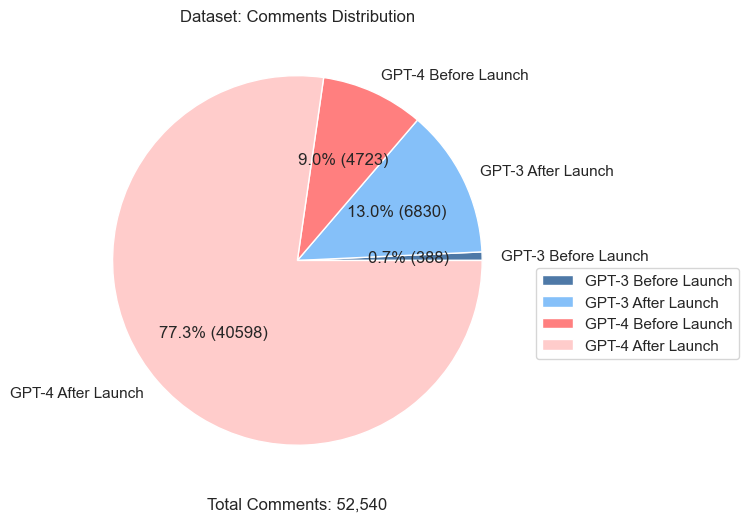

In [13]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_launch = datetime(2022, 11, 30)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

def calculate_launch_dataset(dataset, start, end, launch, label):
    # Filter GPT-3 dataset
    _dataset = dataset.copy()
    subset = dataset[(start <= dataset['date']) & (dataset['date'] < end + timedelta(days=1))]
    subset = subset[(start <= subset['comment_date']) & (subset['comment_date'] < end + timedelta(days=1))]
    # get the distance of the date to the GPT-3 launch date
    subset['launch_distance'] = abs(launch - subset['date'])
    subset['comment_launch_distance'] = abs(launch - subset['comment_date'])
    subset['launch_distance_f'] = subset['launch_distance'] / pd.to_timedelta(1, unit='D')
    subset['comment_launch_distance_f'] = subset['comment_launch_distance'] / pd.to_timedelta(1, unit='D')
    subset['label'] = label
    subset['launched'] = launch <= subset['date']
    ## Output file to csv
    df_to_csv(subset, output_dir, label + '.csv')
    return subset

# Filter GPT-3 dataset
df_gpt3 = calculate_launch_dataset(df, gpt3_start, gpt3_end, gpt3_launch, 'gpt3')
# Split at gpt3_launch date
df_gpt3_before = df_gpt3[df_gpt3['launched'] == False]
df_gpt3_after = df_gpt3[df_gpt3['launched'] == True]

# Filter GPT-4 dataset
df_gpt4 = calculate_launch_dataset(df, gpt4_start, gpt4_end, gpt4_launch, 'gpt4')
# Split at gpt4_launch date
df_gpt4_before = df_gpt4[df_gpt4['launched'] == False]
df_gpt4_after = df_gpt4[df_gpt4['launched'] == True]

# Get counts of datasets before and after launch dates
df_gpt_counts = {
    'GPT-3 Before Launch': len(df_gpt3_before),
    'GPT-3 After Launch': len(df_gpt3_after),
    'GPT-4 Before Launch': len(df_gpt4_before),
    'GPT-4 After Launch': len(df_gpt4_after)
}
# Plot pie chart of GPT search distribution
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#85c0f9', '#ff7f7f', '#ffcccb']  
plt.pie(df_gpt_counts.values(), colors=colors, labels=df_gpt_counts.keys(), autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(df_gpt_counts.values()))})")
# Add annotations for subscriber percentages
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Dataset: Comments Distribution')
plt.ylabel('')
plt.xlabel('Total Comments: ' + "{:,}".format(sum(df_gpt_counts.values())))
plt.show()

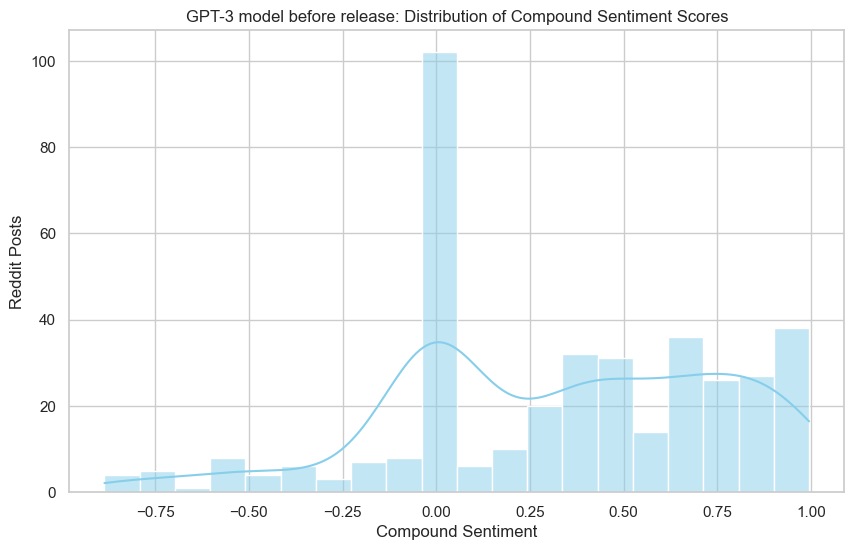

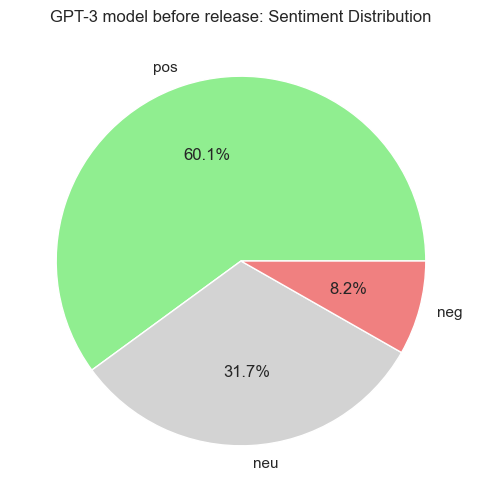

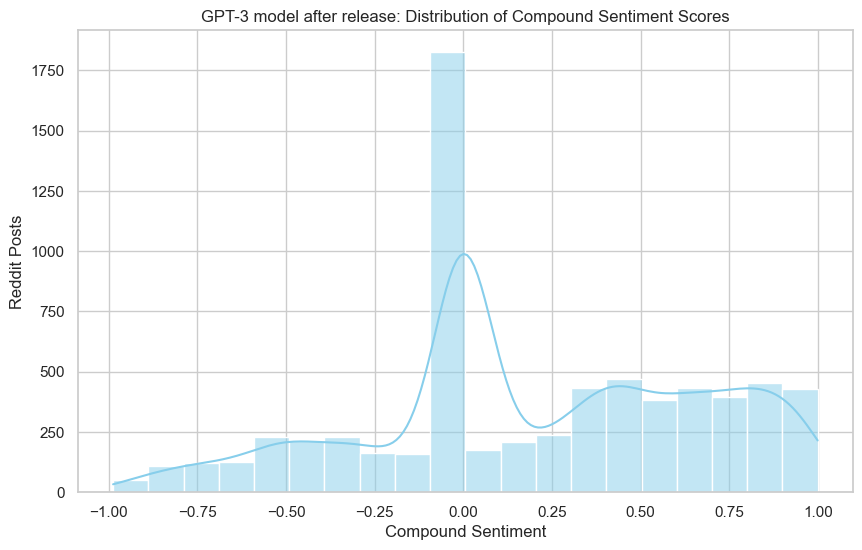

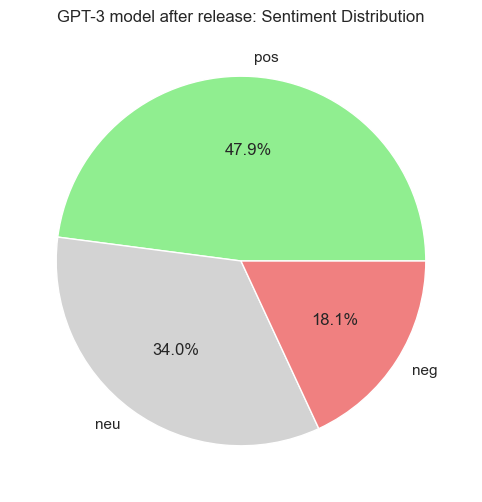

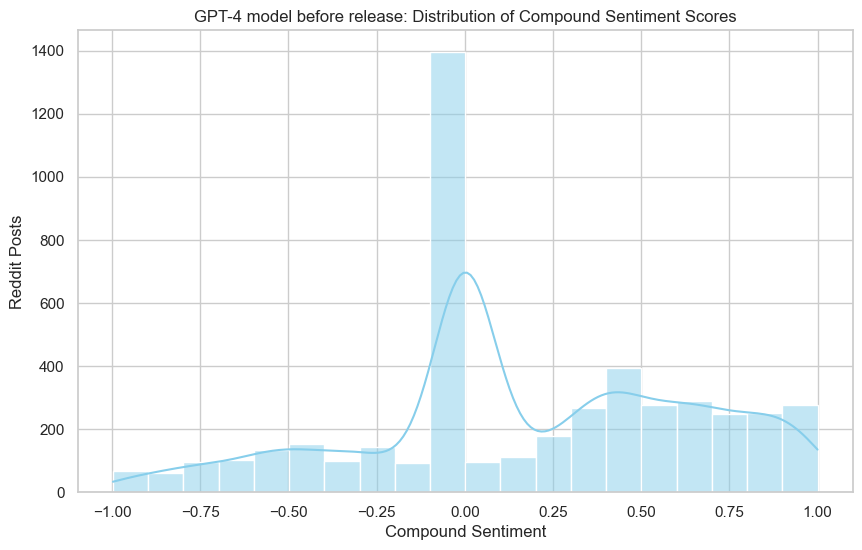

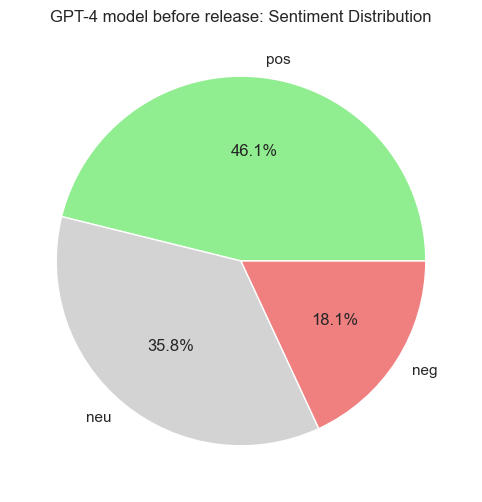

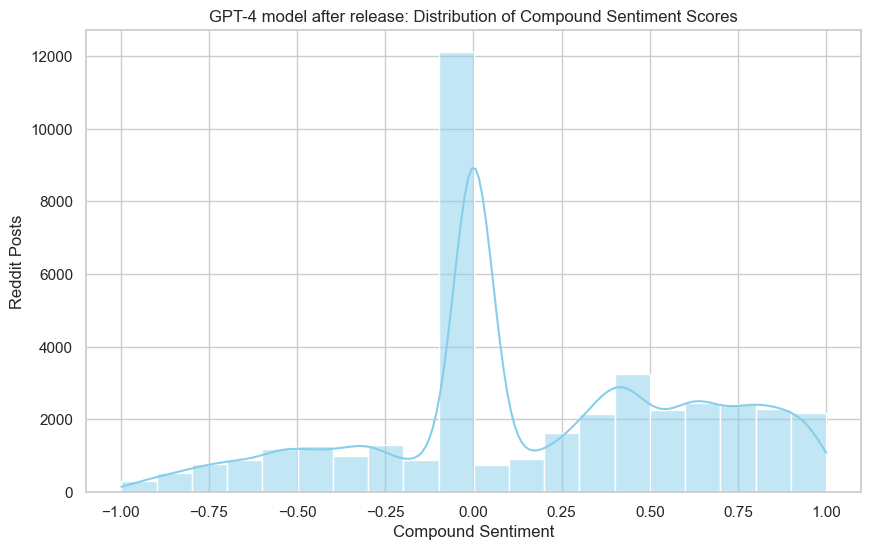

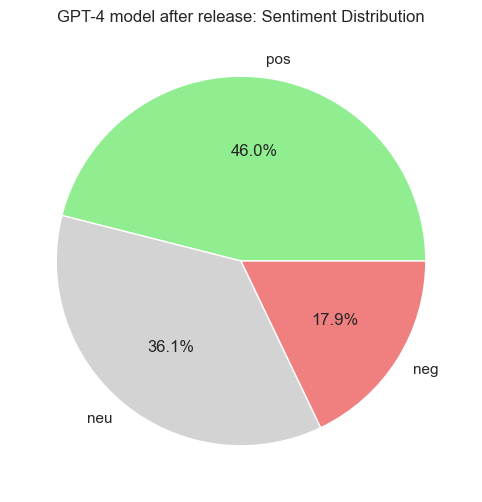

In [14]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='comment_body_compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['comment_body_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3_before, name='GPT-3 model before release')
visualize_sentiment(dataset=df_gpt3_after, name='GPT-3 model after release')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before release')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after release')

# Categorical Distributions

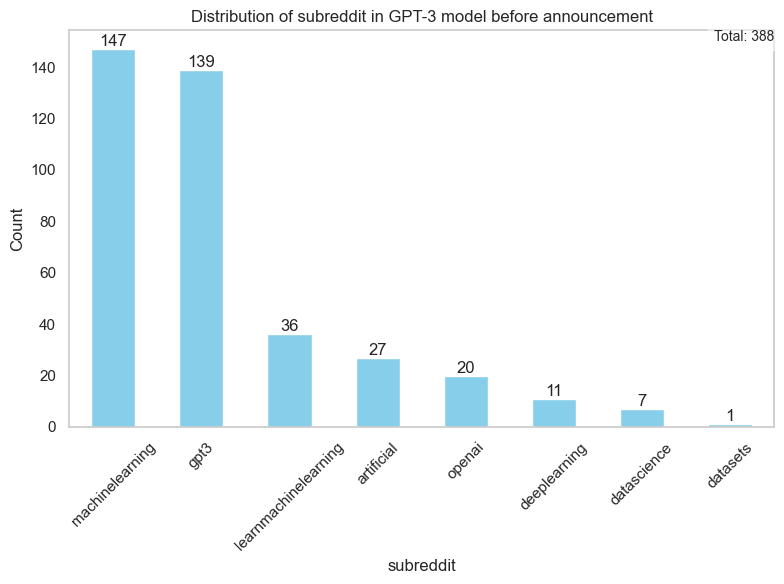

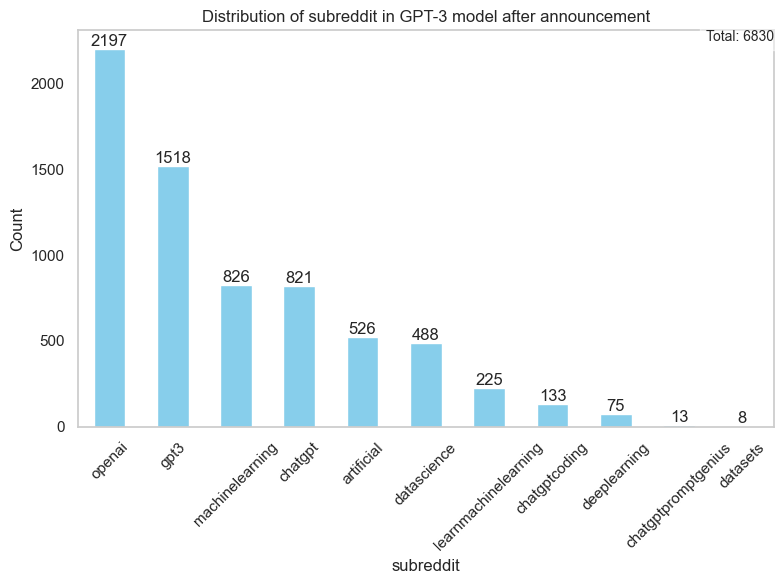

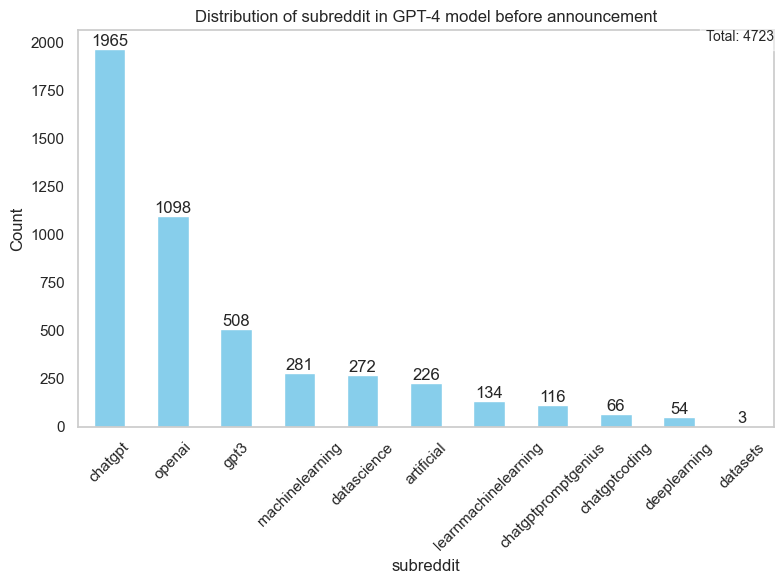

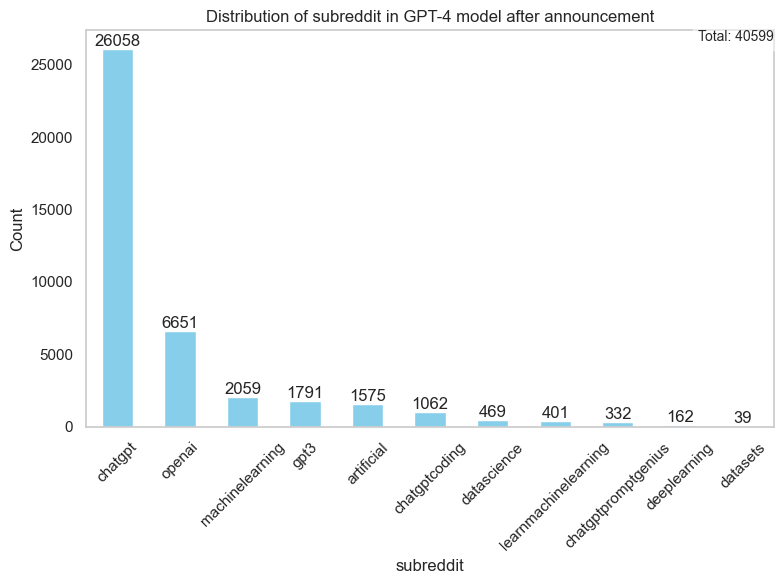

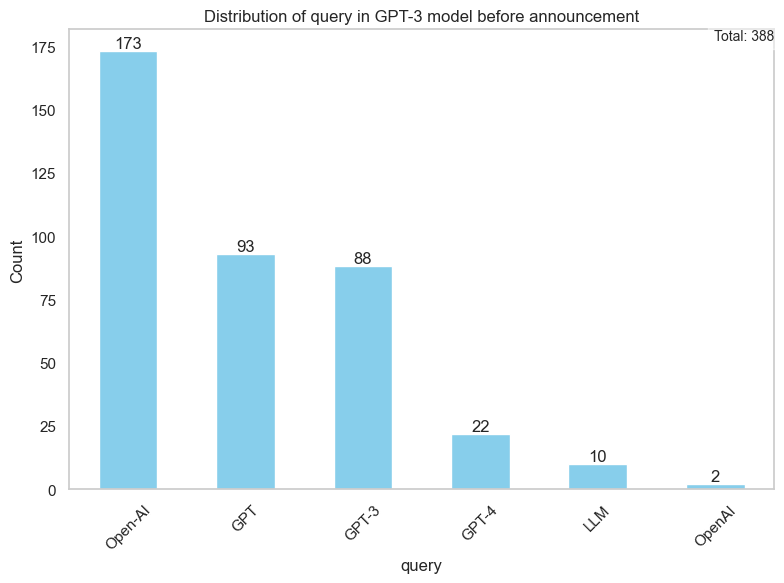

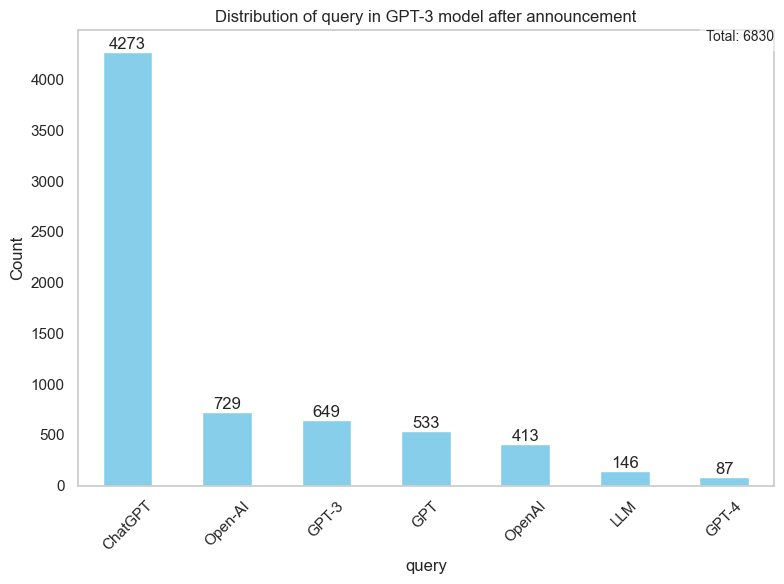

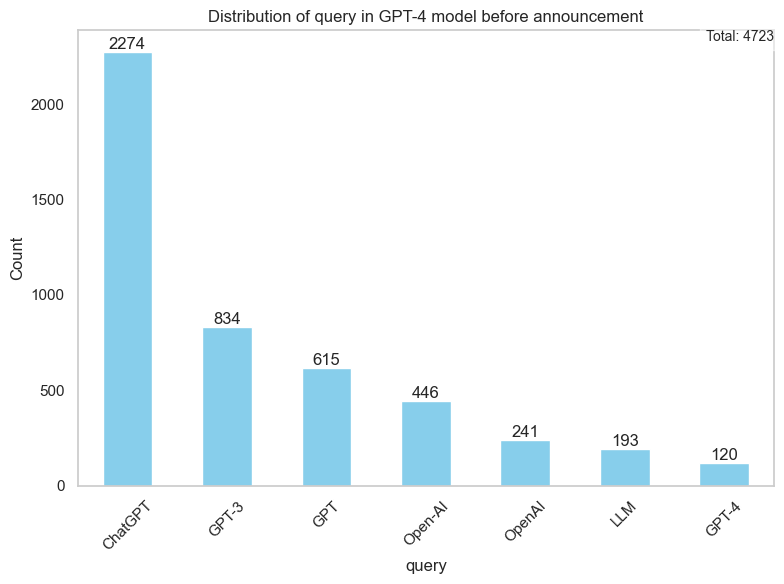

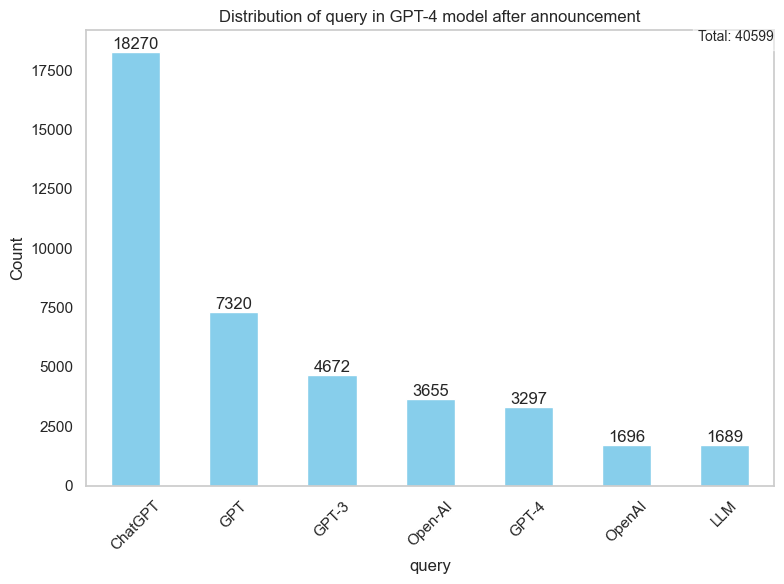

In [15]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3_before, name='GPT-3 model before announcement', category=category)
    plot_distributions(dataset=df_gpt3_after, name='GPT-3 model after announcement', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)